<a href="/assets/tutorial10_example.ipynb" class="link-button">Download</a>
<a href="https://colab.research.google.com/github/technion046195/technion046195/blob/master/content/tutorial10/example.ipynb" target="_blank">
<img src="../assets/colab-badge.svg" style="display:inline"/>
</a>

<center><h1>
תרגול 8 - MLP & Back-propogation
</h1></center>

## Setup

In [ ]:
## Importing packages
import os # A build in package for interacting with the OS. For example to create a folder.
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package
import imageio  # A package to read and write image (is used here to save gif images)
import tabulate  # A package from pretty printing tables
from graphviz import Digraph  # A package for plothing graphs (of nodes and edges)
import torch  ## importing PyTorch
import torch.optim as optim  ## Import the optimization module of the package
import torch.nn as nn
import tqdm.notebook as tqdm

## Setup matplotlib to output figures into the notebook
## - To make the figures interactive (zoomable, tooltip, etc.) use ""%matplotlib notebook" instead
%matplotlib inline

## Setting some nice matplotlib defaults
plt.rcParams['figure.figsize'] = (4.5, 4.5)  # Set default plot's sizes
plt.rcParams['figure.dpi'] = 120  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Auxiliary function for prining equations, pandas tables and images in cells output
from IPython.core.display import display, HTML, Latex, Markdown

## Create output folder
if not os.path.isdir('./output'):
    os.mkdir('./output')

### Data Inspection

In [ ]:
data_file = 'https://technion046195.netlify.app/datasets/wdbc.csv'

## Loading the data
dataset = pd.read_csv(data_file)

dataset

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## Train-Validation-Test split

In [ ]:
n_samples = len(dataset)

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(1)

## Generating a vector of indices
indices = np.arange(n_samples)

## Shuffle the indices
rand_gen.shuffle(indices)

## Split the indices into 60% train / 20% validation / 20% test
n_samples_train = int(n_samples * 0.6)
n_samples_val = int(n_samples * 0.2)
train_indices = indices[:n_samples_train]
val_indices = indices[n_samples_train:(n_samples_train + n_samples_val)]
test_indices = indices[(n_samples_train + n_samples_val):]

train_full_indices = np.concatenate((train_indices, val_indices))

train_full_set = dataset.iloc[train_full_indices]
train_set = dataset.iloc[train_indices]
val_set = dataset.iloc[val_indices]
test_set = dataset.iloc[test_indices]

## 2 Fields MLP

In [ ]:
def extract_x_y(dataset):
    x = dataset[['radius_mean', 'texture_mean']].values
    y = dataset['diagnosis'].values == 'M'
    return x, y

x_train, y_train = extract_x_y(train_set)
x_val, y_val = extract_x_y(val_set)
x_test, y_test = extract_x_y(test_set)

x_grid = np.stack(np.meshgrid(np.arange(5, 35 + 1e-9, 0.01), np.arange(5, 35 + 1e-9, 0.01)), axis=2)

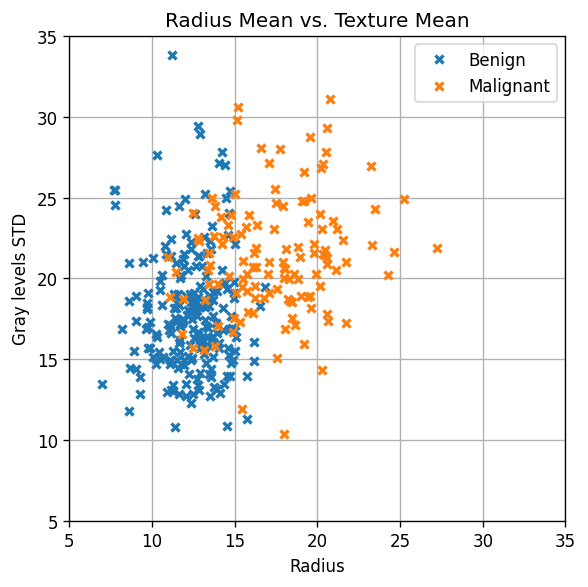

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_train[~y_train, 0], x_train[~y_train, 1], 'x', label='Benign', ms=5, mew=2)
ax.plot(x_train[y_train, 0], x_train[y_train, 1], 'x', label='Malignant', ms=5, mew=2)
ax.set_title('Radius Mean vs. Texture Mean')
ax.set_xlabel('Radius')
ax.set_ylabel('Gray levels STD');
ax.set_xlim(x_grid[0, 0, 0].min(), x_grid[0, -1, 0].max())
ax.set_ylim(x_grid[0, 0, 1].min(), x_grid[-1, 0, 1].max())
plt.tight_layout()
ax.legend(loc='upper right')
fig.savefig('./output/breast_cancer_2d_dataset.png', dpi=240)

In [ ]:
from matplotlib.colors import ListedColormap
def plot_grid_predict(ax, h_func, x_grid):
    cmap = ListedColormap(plt.cm.tab10([0, 1]))
    grid_predict = h_func(x_grid.reshape(-1, 2)).reshape(x_grid.shape[:2])
    img_obj = ax.imshow(grid_predict, extent=[x_grid[0, 0, 0], x_grid[0, -1, 0], x_grid[0, 0, 1], x_grid[-1, 0, 1]],
              origin='lower',
              cmap=cmap,
              alpha=0.2,
              interpolation='nearest',
              zorder=-1,
              aspect='auto',
              )
    return img_obj

In [ ]:
def calc_score(h_func, x, y):
    y_hat = h_func(x)
    score = (y != y_hat).mean()
    return score

In [ ]:
## The gradient decent algorithm
## =============================
def basic_gradient_decent(net, eta, n_iters, x, y, x_val, y_val):
    x = torch.tensor(x, dtype=torch.float)
    y = torch.tensor(y.astype(int), dtype=torch.int)
    x_val = torch.tensor(x_val, dtype=torch.float)
    y_val = torch.tensor(y_val.astype(int), dtype=torch.int)

    ## Set the loss function
    loss_func = nn.BCELoss()
    
    ## Initizalie the optimizer
    opt = optim.SGD(net.parameters(), lr=eta)

    ## Perforing the update steps
    loss_list_train = []
    loss_list_val = []
    for _ in tqdm.tqdm(range(n_iters)):
        opt.zero_grad()
        prob = net(x)
        loss = loss_func(prob, y.float())
        loss.backward()  ## Backward pass
        with torch.no_grad():
            prob_val = net(x_val)
            loss_val = loss_func(prob_val, y_val.float())

            loss_list_train.append(float(loss))
            loss_list_val.append(float(loss_val))
        opt.step()  ## Perform the update step


    loss_list_train = np.array(loss_list_train)
    loss_list_val = np.array(loss_list_val)
    
    return loss_list_train, loss_list_val    

In [ ]:
class MLP1(nn.Module):
    def __init__(self):
        super(MLP1, self).__init__()
        self.mean = None
        self.std = None        
        self.linear1 = nn.Linear(2, 10)
        self.linear2 = nn.Linear(10, 10)
        self.linear3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        torch.random.manual_seed(0)
        torch.nn.init.normal_(self.linear1.weight)
        torch.nn.init.normal_(self.linear2.weight)

    def set_normalization(self, x, y):
        self.mean = x.mean(axis=0, keepdims=True)
        self.std = x.std(axis=0, keepdims=True)
        
    def forward(self, x):
        x = (x - self.mean) / self.std

        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x[:, 0]  ## Reshape x to make it a 1D tensor (vector)

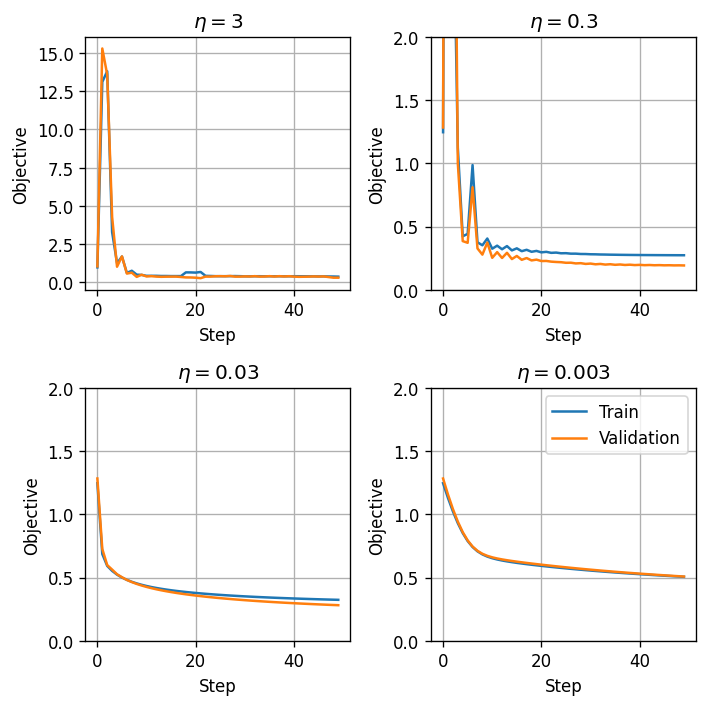

In [ ]:
n_iters = 50
etas_list = (3e0, 3e-1, 3e-2, 3e-3)

# iters_list = np.arange(0, n_iters + 1)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i_eta, eta in enumerate(etas_list):
    net = MLP1()
    net.set_normalization(
        x = torch.tensor(x_train, dtype=torch.float),
        y = torch.tensor(y_train.astype(int), dtype=torch.int),
        )
    loss_list_train, loss_list_val = basic_gradient_decent(net, eta, n_iters, x_train, y_train, x_val, y_val)
    iters_list = np.arange(len(loss_list_train))
    
    ## Plot
    ax = axes.flat[i_eta]
    ax.plot(iters_list, loss_list_train, label='Train')
    ax.plot(iters_list, loss_list_val, label='Validation')
    ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
    ax.set_xlabel('Step')
    ax.set_ylabel('Objective')
axes[0,1].set_ylim(0, 2)
axes[1,0].set_ylim(0, 2)
axes[1,1].set_ylim(0, 2)
axes[1,1].legend()
fig.tight_layout()
fig.savefig('./output/breast_cancer_mlp1_select_eta.png', dpi=240)

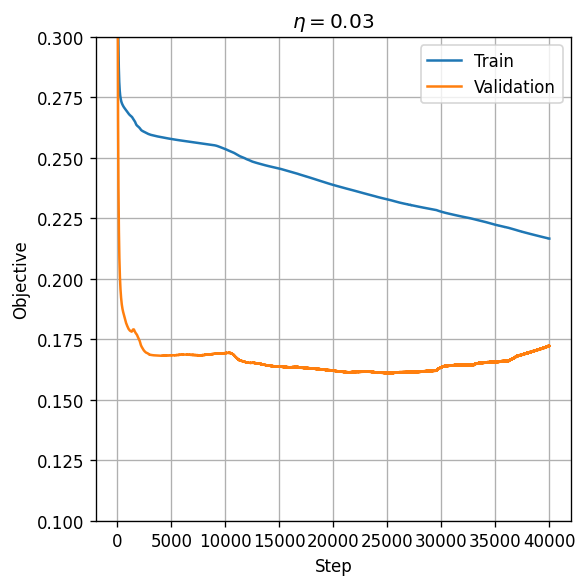

In [ ]:
eta = 3e-2
n_iters = 40000

net = MLP1()
net.set_normalization(
    x = torch.tensor(x_train, dtype=torch.float),
    y = torch.tensor(y_train.astype(int), dtype=torch.int),
    )
loss_list_train, loss_list_val = basic_gradient_decent(net, eta, n_iters, x_train, y_train, x_val, y_val)
iters_list = np.arange(len(loss_list_train))

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(iters_list, loss_list_train, label='Train')
ax.plot(iters_list, loss_list_val, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.set_ylim([0.1, 0.3])
ax.legend()
fig.tight_layout()
fig.savefig('./output/breast_cancer_mlp1_train.png', dpi=240)

25262



The misclassification rate on the validation is: 0.08


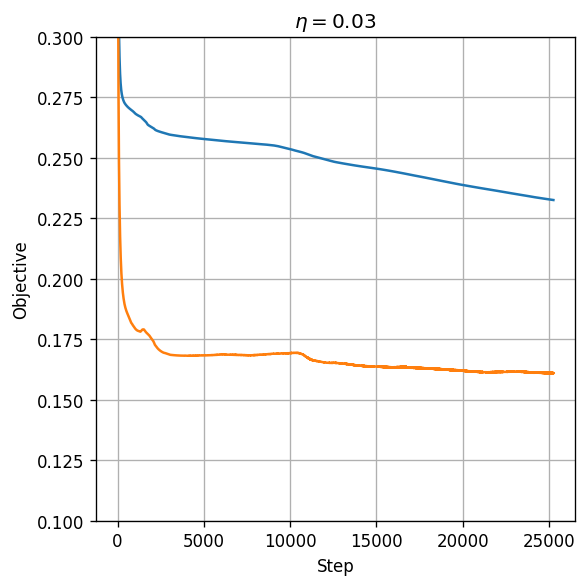

In [ ]:
n_iters = np.argmin(loss_list_val)
print(n_iters)

net = MLP1()
net.set_normalization(
    x = torch.tensor(x_train, dtype=torch.float),
    y = torch.tensor(y_train.astype(int), dtype=torch.int),
    )
loss_list_train, loss_list_val = basic_gradient_decent(net, eta, n_iters, x_train, y_train, x_val, y_val)
iters_list = np.arange(len(loss_list_train))

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(iters_list, loss_list_train, label='Train')
ax.plot(iters_list, loss_list_val, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.set_ylim([0.1, 0.3])
fig.tight_layout()

h_func = lambda x: net(torch.tensor(x, dtype=torch.float)).detach().numpy() > 0.5

print(f'The misclassification rate on the validation is: {calc_score(h_func, x_val, y_val):.2f}')

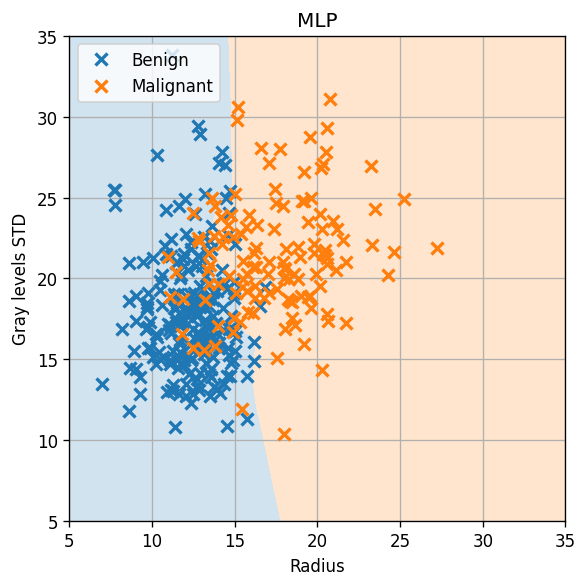

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_train[~y_train, 0], x_train[~y_train, 1], 'x', label='Benign', ms=7, mew=2)
ax.plot(x_train[y_train, 0], x_train[y_train, 1], 'x', label='Malignant', ms=7, mew=2)
plot_grid_predict(ax, h_func, x_grid)
ax.set_title('MLP')
ax.set_xlabel('Radius')
ax.set_ylabel('Gray levels STD');
ax.set_xlim(x_grid[0, 0, 0].min(), x_grid[0, -1, 0].max())
ax.set_ylim(x_grid[0, 0, 1].min(), x_grid[-1, 0, 1].max())
plt.tight_layout()
ax.legend(loc='upper left')
fig.savefig('./output/breast_cancer_mlp1.png', dpi=240)

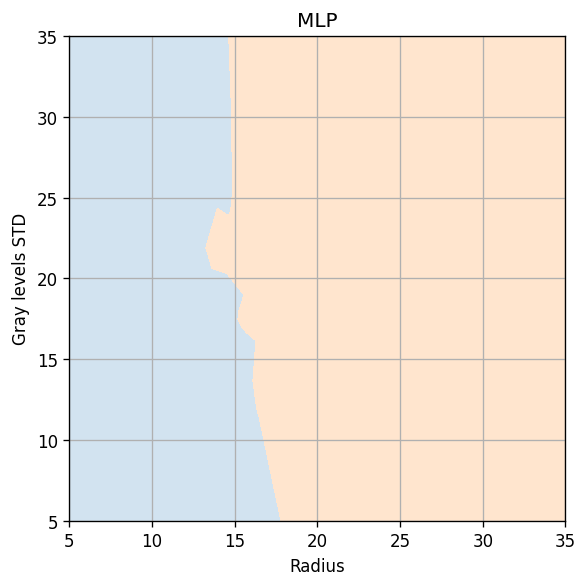

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_grid_predict(ax, h_func, x_grid)
ax.set_title('MLP')
ax.set_xlabel('Radius')
ax.set_ylabel('Gray levels STD');
ax.set_xlim(x_grid[0, 0, 0].min(), x_grid[0, -1, 0].max())
ax.set_ylim(x_grid[0, 0, 1].min(), x_grid[-1, 0, 1].max())
plt.tight_layout()
fig.savefig('./output/breast_cancer_mlp1_no_samples.png', dpi=240)

## All Fields MLP

In [ ]:
features_names_list = ['radius_mean', 'texture_mean', 'perimeter_mean',
                       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
                       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
                       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
                       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
                       'fractal_dimension_se', 'radius_worst', 'texture_worst',
                       'perimeter_worst', 'area_worst', 'smoothness_worst',
                       'compactness_worst', 'concavity_worst', 'concave points_worst',
                       'symmetry_worst', 'fractal_dimension_worst']

def extract_x_y(dataset):
    x = dataset[features_names_list].values
    y = dataset['diagnosis'].values == 'M'
    return x, y
x_train, y_train = extract_x_y(train_set)
x_val, y_val = extract_x_y(val_set)
x_test, y_test = extract_x_y(test_set)


In [ ]:
class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.mean = None
        self.std = None        
        self.linear1 = nn.Linear(30, 10)
        self.linear2 = nn.Linear(10, 10)
        self.linear3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        torch.random.manual_seed(0)
        torch.nn.init.normal_(self.linear1.weight)
        torch.nn.init.normal_(self.linear2.weight)

    def set_normalization(self, x, y):
        self.mean = x.mean(axis=0, keepdims=True)
        self.std = x.std(axis=0, keepdims=True)
        
    def forward(self, x):
        x = (x - self.mean) / self.std

        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x[:, 0]  ## Reshape x to make it a 1D tensor (vector)

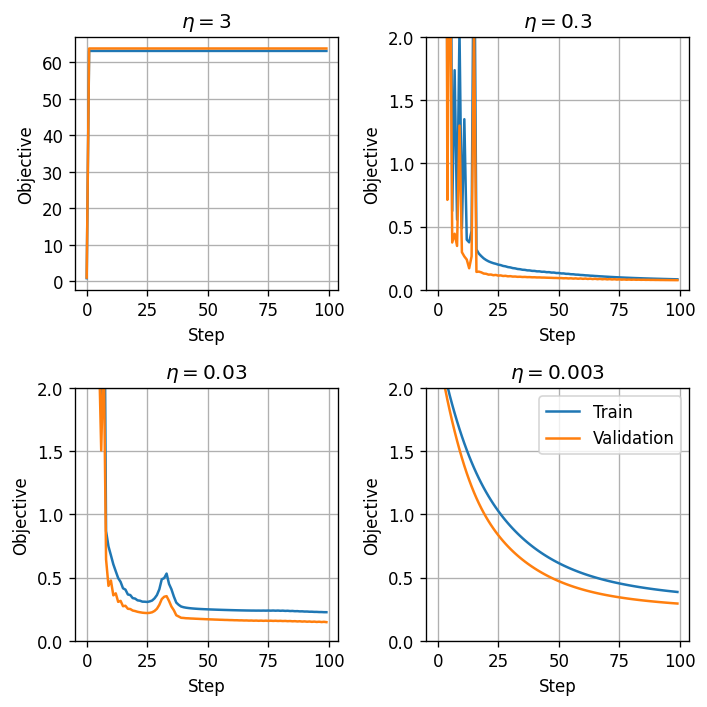

In [ ]:
n_iters = 100
etas_list = (3e0, 3e-1, 3e-2, 3e-3)
# etas_list = (1e1, 1e0, 1e-1, 1e-2)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i_eta, eta in enumerate(etas_list):
    net = MLP2()
    net.set_normalization(
        x = torch.tensor(x_train, dtype=torch.float),
        y = torch.tensor(y_train.astype(int), dtype=torch.int),
        )
    loss_list_train, loss_list_val = basic_gradient_decent(net, eta, n_iters, x_train, y_train, x_val, y_val)
    iters_list = np.arange(len(loss_list_train))
    
    ## Plot
    ax = axes.flat[i_eta]
    ax.plot(iters_list, loss_list_train, label='Train')
    ax.plot(iters_list, loss_list_val, label='Validation')
    ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
    ax.set_xlabel('Step')
    ax.set_ylabel('Objective')
axes[0,1].set_ylim(0, 2)
axes[1,0].set_ylim(0, 2)
axes[1,1].set_ylim(0, 2)
axes[1,1].legend()
fig.tight_layout()
fig.savefig('./output/breast_cancer_mlp2_select_eta.png', dpi=240)

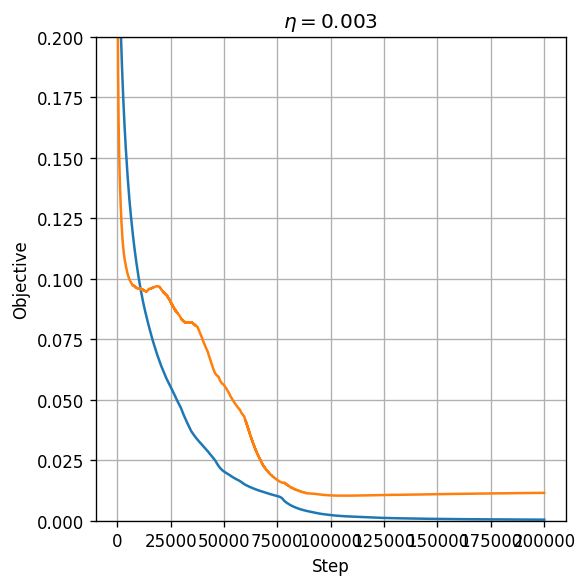

In [ ]:
eta = 3e-3
n_iters = 200000

net = MLP2()
net.set_normalization(
    x = torch.tensor(x_train, dtype=torch.float),
    y = torch.tensor(y_train.astype(int), dtype=torch.int),
    )
loss_list_train, loss_list_val = basic_gradient_decent(net, eta, n_iters, x_train, y_train, x_val, y_val)
iters_list = np.arange(len(loss_list_train))

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(iters_list, loss_list_train, label='Train')
ax.plot(iters_list, loss_list_val, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.set_ylim([0, 0.2])
fig.tight_layout()
fig.savefig('./output/breast_cancer_mlp2_train.png', dpi=240)

106956



The misclassification rate on the validation is: 0.01


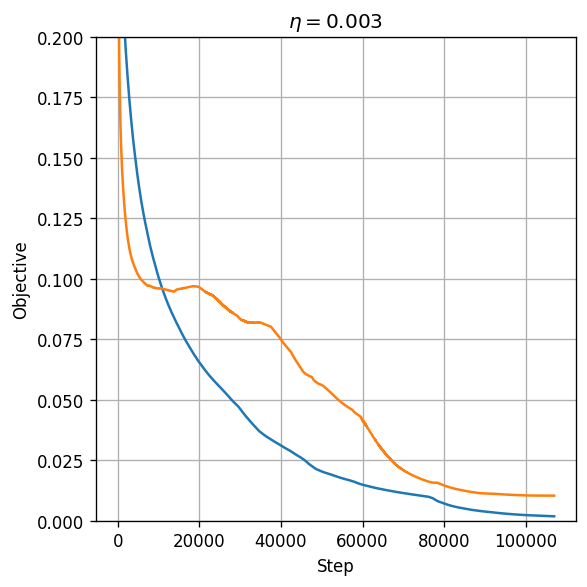

In [ ]:
n_iters = np.argmin(loss_list_val)
print(n_iters)

net = MLP2()
net.set_normalization(
    x = torch.tensor(x_train, dtype=torch.float),
    y = torch.tensor(y_train.astype(int), dtype=torch.int),
    )
loss_list_train, loss_list_val = basic_gradient_decent(net, eta, n_iters, x_train, y_train, x_val, y_val)
iters_list = np.arange(len(loss_list_train))

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(iters_list, loss_list_train, label='Train')
ax.plot(iters_list, loss_list_val, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.set_ylim([0, 0.2])
fig.tight_layout()

h_func = lambda x: net(torch.tensor(x, dtype=torch.float)).detach().numpy() > 0.5

print(f'The misclassification rate on the validation is: {calc_score(h_func, x_val, y_val):.2f}')

In [ ]:
print(f'The misclassification rate on the test is: {calc_score(h_func, x_test, y_test):.2f}')

The misclassification rate on the test is: 0.03
